In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import timedelta

# 한글 폰트 설정
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':  # MacOS
    rc('font', family='AppleGothic')
else:
    print("Unsupported OS")

path = '../dataset/data/'
# CSV 파일 로드
blog_df = pd.read_csv(path + "BLOG.csv")
buy_list_df = pd.read_csv(path + 'BUY_LIST.csv')
deal_list_df = pd.read_csv(path + 'DEAL_LIST.csv')
release_price_df = pd.read_csv(path + 'RELEASE_PRICE.csv')
sell_list_df = pd.read_csv(path + 'SELL_LIST.csv')

# deal_list_df 데이터를 날짜별로 묶어서 price의 평균값 계산
deal_list_df['date'] = pd.to_datetime(deal_list_df['date'], format='%y/%m/%d')
deal_avg_df = deal_list_df.groupby(['model', 'date']).agg({'price': 'mean'}).reset_index()

# 데이터 결합
merged_df = deal_avg_df.merge(blog_df, on='model', how='left')\
                       .merge(buy_list_df.groupby('model').agg({'b_price': 'mean', 'b_count': 'sum'}).reset_index(), on='model', how='left')\
                       .merge(release_price_df.reset_index(), on='model', how='left')\
                       .merge(sell_list_df.groupby('model').agg({'s_price': 'mean', 's_count': 'sum'}).reset_index(), on='model', how='left')

# 결측값 처리: 결측값이 많은 컬럼 제거
threshold = 0.3  # 30% 이상의 결측값이 있는 컬럼은 제거
missing_percentage = merged_df.isnull().sum() / len(merged_df)
columns_to_drop = missing_percentage[missing_percentage > threshold].index
merged_df = merged_df.drop(columns=columns_to_drop)

# 나머지 결측값 처리: 평균값으로 채움
merged_df.fillna(merged_df.mean(numeric_only=True), inplace=True)

# 새로운 특성 생성
merged_df['price_ratio'] = merged_df['s_price'] / merged_df['b_price']

# 로그 변환: price에 로그 변환 적용
merged_df['log_price'] = np.log1p(merged_df['price'])

# 날짜 열 변환 (YY/MM/DD 형식)
merged_df['date'] = pd.to_datetime(merged_df['date'], format='%y/%m/%d')
merged_df = merged_df.sort_values('date')

# 시계열 특성 생성
def create_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    return df

# 특성 생성
merged_df = create_features(merged_df)

예측할 모델명을 입력하세요:  나이키 ACG 워터캣+ 팬텀


C:\Users\User\AppData\Local\Temp\ipykernel_18600\928480469.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([result_df, future_result_df])


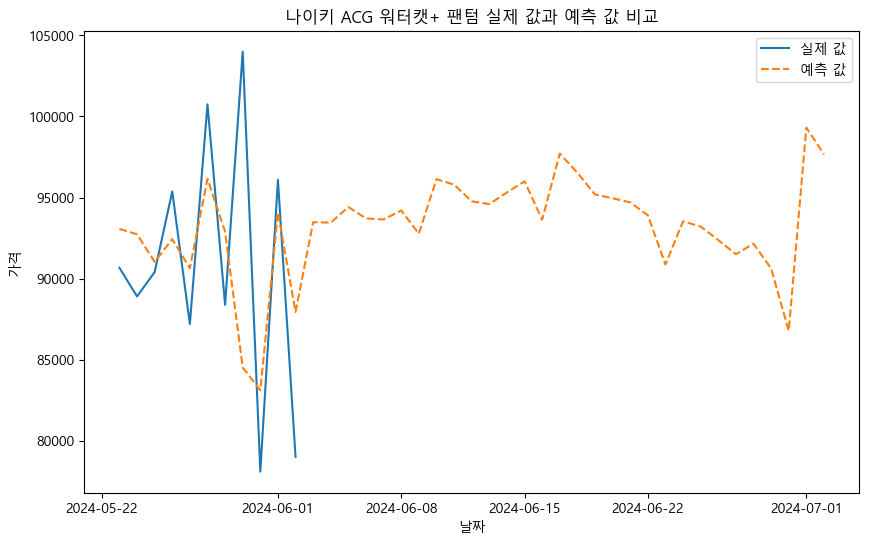

         date   actual_price  predicted_price
0  2024-05-23   90666.666667     93063.637447
1  2024-05-24   88900.000000     92734.960347
2  2024-05-25   90400.000000     91034.564906
3  2024-05-26   95375.000000     92435.138286
4  2024-05-27   87200.000000     90637.640403
5  2024-05-28  100750.000000     96158.818555
6  2024-05-29   88380.952381     92888.928940
7  2024-05-30  104000.000000     84521.142321
8  2024-05-31   78090.909091     83106.509556
9  2024-06-01   96100.000000     94090.068648
10 2024-06-02   79000.000000     87940.157287
0  2024-06-03            NaN     93478.956781
1  2024-06-04            NaN     93452.974943
2  2024-06-05            NaN     94417.048594
3  2024-06-06            NaN     93710.667526
4  2024-06-07            NaN     93647.229651
5  2024-06-08            NaN     94202.289521
6  2024-06-09            NaN     92771.534019
7  2024-06-10            NaN     96134.360810
8  2024-06-11            NaN     95797.418166
9  2024-06-12            NaN     9

In [ ]:
model = joblib.load('../models/random_forest_model.pkl')
scaler = joblib.load('../models/scaler.pkl')

# 사용자로부터 모델명 입력받기
model_name = input("예측할 모델명을 입력하세요: ")

# 특정 모델 선택
model_df = merged_df[merged_df['model'] == model_name].copy()

# 필요 없는 열 제거
model_df = model_df.reset_index(drop=True)

# 실제 값과 예측 값 생성
X = model_df[['total', 'b_price', 'release_price', 's_price', 'price_ratio', 'year', 'month', 'day', 'dayofweek']]
y_actual_log = model_df['log_price']

# 특성 스케일링
X_scaled = scaler.transform(X)

# 예측 수행
y_pred_log = model.predict(X_scaled)

# 예측 값을 원래 스케일로 변환
y_pred = np.expm1(y_pred_log)

# 실제 값을 원래 스케일로 변환
y_actual = np.expm1(y_actual_log)

# 미래 날짜 생성
last_date = model_df['date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30)

# 미래 데이터를 위한 데이터프레임 생성
future_df = pd.DataFrame({'date': future_dates})
future_df = create_features(future_df)

# 미래 데이터에 기존 데이터의 평균값 사용
for col in ['total', 'b_price', 'release_price', 's_price', 'price_ratio']:
    future_df[col] = model_df[col].mean()

# 특성 스케일링
future_X_scaled = scaler.transform(future_df[['total', 'b_price', 'release_price', 's_price', 'price_ratio', 'year', 'month', 'day', 'dayofweek']])

# 미래 예측 수행
future_pred_log = model.predict(future_X_scaled)

# 미래 예측 값을 원래 스케일로 변환
future_pred = np.expm1(future_pred_log)

# 실제 값과 예측 값 데이터프레임 생성
result_df = pd.DataFrame({
    'date': model_df['date'],
    'actual_price': y_actual,
    'predicted_price': y_pred
})

# 미래 예측 데이터프레임 생성
future_result_df = pd.DataFrame({
    'date': future_dates,
    'actual_price': [None] * len(future_dates),
    'predicted_price': future_pred
})

# 결과 데이터프레임 결합
combined_df = pd.concat([result_df, future_result_df])

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(combined_df['date'], combined_df['actual_price'], label='실제 값', linestyle='-')
plt.plot(combined_df['date'], combined_df['predicted_price'], label='예측 값', linestyle='--')
plt.xlabel('날짜')
plt.ylabel('가격')
plt.title(f'{model_name} 실제 값과 예측 값 비교')
plt.legend()
plt.show()

# 결과 출력
print(combined_df)

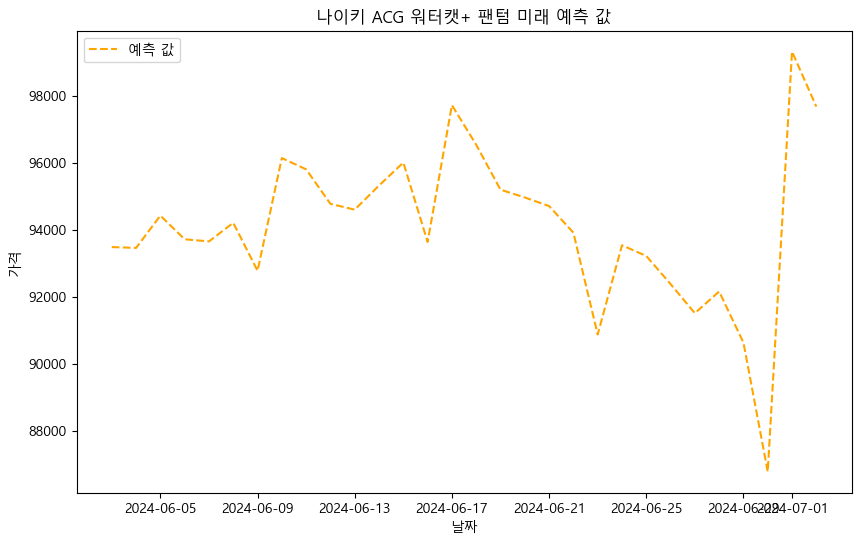

         date actual_price  predicted_price
0  2024-06-03         None     93478.956781
1  2024-06-04         None     93452.974943
2  2024-06-05         None     94417.048594
3  2024-06-06         None     93710.667526
4  2024-06-07         None     93647.229651
5  2024-06-08         None     94202.289521
6  2024-06-09         None     92771.534019
7  2024-06-10         None     96134.360810
8  2024-06-11         None     95797.418166
9  2024-06-12         None     94767.694793
10 2024-06-13         None     94594.439826
11 2024-06-14         None     95314.917047
12 2024-06-15         None     96000.180891
13 2024-06-16         None     93631.387375
14 2024-06-17         None     97712.436936
15 2024-06-18         None     96530.126811
16 2024-06-19         None     95190.744906
17 2024-06-20         None     94957.703037
18 2024-06-21         None     94702.032201
19 2024-06-22         None     93907.870743
20 2024-06-23         None     90869.650510
21 2024-06-24         None     9

In [4]:
# 미래 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(future_result_df['date'], future_result_df['predicted_price'], label='예측 값', linestyle='--', color='orange')
plt.xlabel('날짜')
plt.ylabel('가격')
plt.title(f'{model_name} 미래 예측 값')
plt.legend()
plt.show()

# 미래 예측 결과 출력
print(future_result_df)
